In [0]:
# This is the code that was used to generate the results for Chapter 4 of Jermy
# Thomas' MS Thesis. 

# The main purpose of this code is to:

# 1. Calculate PMV
# 2. Calculate MET_HR
# 3. Calculate PMV_Adjusted
# 4. Plot PMV, PMV_adjusted, and the PMV variables for each particpant.
# 5. Calculate MAE and MSE for PMV and PMV adjusted

# Dependency:

# The dataset from Chapter 3

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

In [0]:
dataset = pd.read_csv("All.csv")

In [0]:
# Code to calculate PMV
# Not my code in this cell. 


import math



def comfPMV(ta, tr, vel, rh, met, clo, wme):
    """
    returns [pmv, ppd]
    ta, air temperature (C)
    tr, mean radiant temperature (C)
    vel, relative air velocity (m/s)
    rh, relative humidity (%) Used only this way to input humidity level
    met, metabolic rate (met)
    clo, clothing (clo)
    wme, external work, normally around 0 (met)
    """

    pa = rh * 10 * math.exp(16.6536 - 4030.183 / (ta + 235))

    icl = 0.155 * clo  # thermal insulation of the clothing in M2K/W
    m = met * 58.15  # metabolic rate in W/M2
    w = wme * 58.15  # external work in W/M2
    mw = m - w  # internal heat production in the human body
    if (icl <= 0.078):
        fcl = 1 + (1.29 * icl)
    else:
        fcl = 1.05 + (0.645 * icl)

    # heat transf. coeff. by forced convection
    hcf = 12.1 * math.sqrt(vel)
    taa = ta + 273
    tra = tr + 273
    tcla = taa + (35.5 - ta) / (3.5 * icl + 0.1)

    p1 = icl * fcl
    p2 = p1 * 3.96
    p3 = p1 * 100
    p4 = p1 * taa
    p5 = (308.7 - 0.028 * mw) + (p2 * math.pow(tra / 100, 4))
    xn = tcla / 100
    xf = tcla / 50
    eps = 0.00015

    n = 0
    while abs(xn - xf) > eps:
        xf = (xf + xn) / 2
        hcn = 2.38 * math.pow(abs(100.0 * xf - taa), 0.25)
        if (hcf > hcn):
            hc = hcf
        else:
            hc = hcn
        xn = (p5 + p4 * hc - p2 * math.pow(xf, 4)) / (100 + p3 * hc)
        n += 1
        if (n > 150):
            print( 'Max iterations exceeded')
            return 1


    tcl = 100 * xn - 273

    # heat loss diff. through skin
    hl1 = 3.05 * 0.001 * (5733 - (6.99 * mw) - pa)
    # heat loss by sweating
    if mw > 58.15:
        hl2 = 0.42 * (mw - 58.15)
    else:
        hl2 = 0
    # latent respiration heat loss
    hl3 = 1.7 * 0.00001 * m * (5867 - pa)
    # dry respiration heat loss
    hl4 = 0.0014 * m * (34 - ta)
    # heat loss by radiation
    hl5 = 3.96 * fcl * (math.pow(xn, 4) - math.pow(tra / 100, 4))
    # heat loss by convection
    hl6 = fcl * hc * (tcl - ta)

    ts = 0.303 * math.exp(-0.036 * m) + 0.028
    pmv = ts * (mw - hl1 - hl2 - hl3 - hl4 - hl5 - hl6)
    ppd = 100.0 - 95.0 * math.exp(-0.03353 * pow(pmv, 4.0)
        - 0.2179 * pow(pmv, 2.0))

    r = []
    r.append(pmv)
    r.append(ppd)

    return r


In [0]:
# Function to determine min HR for each person

def minHR(subjectValue,dataframe):
  sub_df  = dataframe.loc[df['Subject'] == subjectValue]
  HRmin = sub_df['HR'].min()
  
  return HRmin

In [0]:
# Next three cells calculate PMV

df = pd.DataFrame(dataset)
df['WindSpd'] = df.apply(lambda row: (row['V_a_110']+row['V_a_50'])/2,axis = 1) # Windspeed is the average of all three Air speeds
df['PMV'] = df.apply(lambda row: comfPMV(row['Temp.1'],row['MRT'],row['WindSpd'],row['RH'],row['Activity'],row['Clo'],0)[0],axis = 1)  # Calculate PMV 
# df = df.drop(['WindSpd'], axis=1)
dataset = df

In [0]:

df = dataset

df['HR_MET'] = df.apply(lambda row: (row['HR']/minHR(row['Subject'],df)),axis = 1)  # Calculate new MET from HR
df['HR_PMV'] = df.apply(lambda row: comfPMV(row['Temp.1'],row['MRT'],row['WindSpd'],row['RH'],row['HR_MET'],row['Clo'],0)[0],axis = 1)  # Calculate Modified PMV 
# df = df.drop(['WindSpd'], axis=1)
dataset = df
 

In [0]:
df = dataset

df = df.drop(['T_db_10', 'V_a_10'], axis=1)

dataset = df

In [0]:
df = df.rename({'Temp.1': 'Temperature'}, axis='columns')

In [0]:


# matplotlib.rcParams['text.usetex'] = True

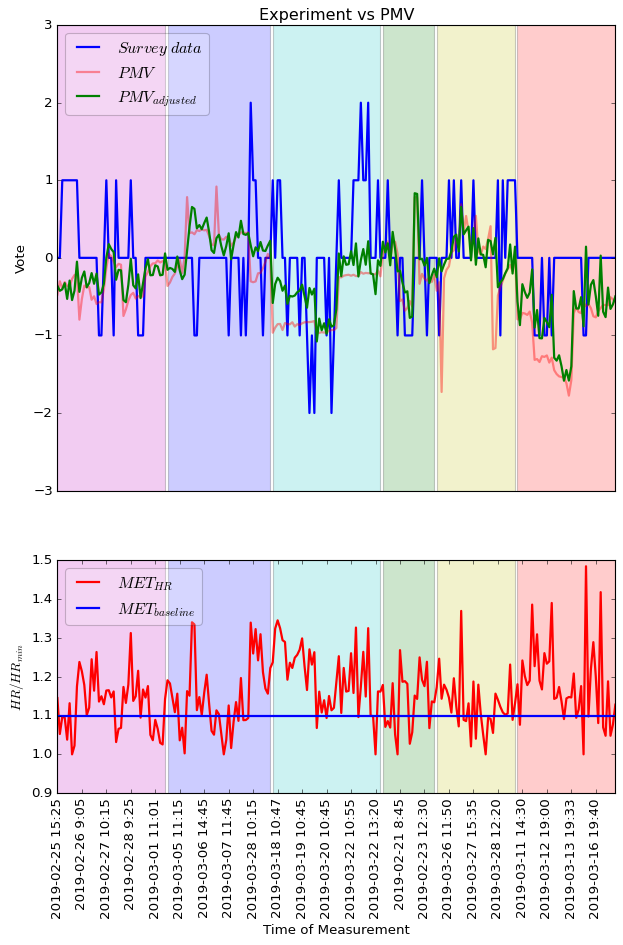

In [0]:
# New Plot code


%matplotlib inline

plt.style.use('classic')

fig, (ax, ax2) = plt.subplots(2, 1,
                              gridspec_kw={'height_ratios':[2,1]}, 
                              figsize=(9,12))


fig.patch.set_facecolor('white')

# heights = [5, 2]
# fig.add_gridspec(ncols=1, nrows=2,height_ratios = heights)
# fig.subplots_adjust(hspace=0.5)
dataset['baseline_MET'] = 1.1

ax.plot(dataset['Unnamed: 0'], dataset[ 'General Sensation'], 'b-', label=r'$Survey\;data$', linewidth=2);
ax.plot(dataset['Unnamed: 0'], dataset[ 'PMV'],  'r-', label=r'$PMV$', linewidth=2, alpha = 0.4);
ax.plot(dataset['Unnamed: 0'], dataset[ 'HR_PMV'],  'g-', label=r'$PMV_{adjusted}$', linewidth=2);


# start, end = ax2.get_xlim()
# xlabels = np.arange(start, end, 10)
# ax.xaxis.set_ticks(np.arange(start, end, 10))
# ax.set_xticklabels(xlabels,rotation=90)

ax.axvspan(dataset['Unnamed: 0'].iloc[0],dataset['Unnamed: 0'].iloc[44], facecolor='m', alpha=0.2)
ax.axvspan(dataset['Unnamed: 0'].iloc[45],dataset['Unnamed: 0'].iloc[87], facecolor='b', alpha=0.2)
ax.axvspan(dataset['Unnamed: 0'].iloc[88],dataset['Unnamed: 0'].iloc[132], facecolor='c', alpha=0.2)
ax.axvspan(dataset['Unnamed: 0'].iloc[133],dataset['Unnamed: 0'].iloc[154], facecolor='g', alpha=0.2)
ax.axvspan(dataset['Unnamed: 0'].iloc[155],dataset['Unnamed: 0'].iloc[187], facecolor='y', alpha=0.2)
ax.axvspan(dataset['Unnamed: 0'].iloc[188],dataset['Unnamed: 0'].iloc[228], facecolor='r', alpha=0.2)

# ax.plot(dataset['Unnamed: 0'], dataset[ 'NewMET_PMV'],  'm-', label='NewMET_PMV', linewidth=2);
plt.xticks(rotation=90)
ax.legend(fancybox=True, framealpha=0.2, loc = 'upper left');


start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 10))
ax.set_xticks([])

ax2.plot(dataset['Unnamed: 0'], dataset[ 'HR_MET'],  'r-', label=r'$MET_{HR}$', linewidth=2);
ax2.plot(dataset['Unnamed: 0'], dataset[ 'baseline_MET'],  'b-', label=r'$MET_{baseline}$', linewidth=2);

ax2.axvspan(dataset['Unnamed: 0'].iloc[0],dataset['Unnamed: 0'].iloc[44], facecolor='m', alpha=0.2)
ax2.axvspan(dataset['Unnamed: 0'].iloc[45],dataset['Unnamed: 0'].iloc[87], facecolor='b', alpha=0.2)
ax2.axvspan(dataset['Unnamed: 0'].iloc[88],dataset['Unnamed: 0'].iloc[132], facecolor='c', alpha=0.2)
ax2.axvspan(dataset['Unnamed: 0'].iloc[133],dataset['Unnamed: 0'].iloc[154], facecolor='g', alpha=0.2)
ax2.axvspan(dataset['Unnamed: 0'].iloc[155],dataset['Unnamed: 0'].iloc[187], facecolor='y', alpha=0.2)
ax2.axvspan(dataset['Unnamed: 0'].iloc[188],dataset['Unnamed: 0'].iloc[228], facecolor='r', alpha=0.2)


# start, end = ax2.get_xlim()
# ax2.xaxis.set_ticks(np.arange(start, end, 10))

ax2.legend(fancybox=True, framealpha=0.2, loc = 'upper left');

# xlabels = np.arange(start, end, 10)
ax2.xaxis.set_ticks(np.arange(start, end, 10))
# ax.set_xticklabels(xlabels,rotation=90)

ax.set_title("Experiment vs PMV")
plt.xlabel('Time of Measurement')
ax.set_ylabel('Vote');
ax2.set_ylabel('$HR/HR_{min}$');

plt.axis('tight');

ax.set_ylim([-3,3]);
ax2.set_ylim([0.9, 1.5]);

filenameExperiment = "ExperimentHR.png"
plt.savefig(filenameExperiment)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


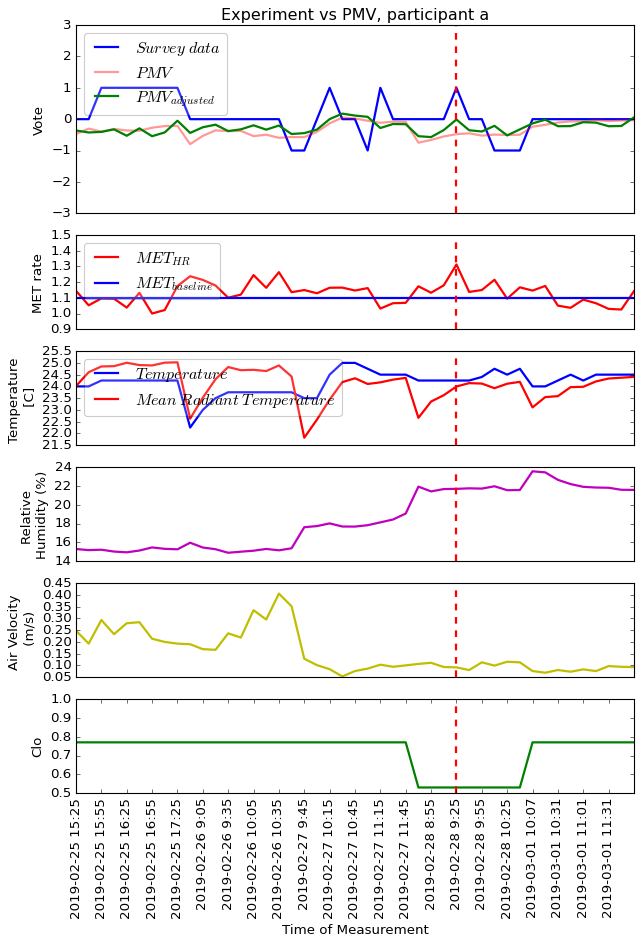

In [0]:
# Participant a


%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('classic')

dataset_unique = dataset[dataset['Subject'] == 'a']

fig, (ax, ax2,ax3,ax4,ax5, ax6) = plt.subplots(6, 1,
                              gridspec_kw={'height_ratios':[2,1,1,1,1, 1]}, 
                              figsize=(9,12))

fig.patch.set_facecolor('white')


dataset_unique['baseline_MET'] = 1.1

ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'General Sensation'], 'b-', label=r'$Survey\;data$', linewidth=2);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'PMV'],  'r-', label= r'$PMV$', linewidth=2, alpha = 0.4);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_PMV'],  'g-', label= r'$PMV_{adjusted}$', linewidth=2);


# # start, end = ax2.get_xlim()
# # xlabels = np.arange(start, end, 10)
# # ax.xaxis.set_ticks(np.arange(start, end, 10))
# # ax.set_xticklabels(xlabels,rotation=90)

# ax.axvspan(dataset['Unnamed: 0'].iloc[0],dataset['Unnamed: 0'].iloc[44], facecolor='m', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[45],dataset['Unnamed: 0'].iloc[87], facecolor='b', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[88],dataset['Unnamed: 0'].iloc[132], facecolor='c', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[133],dataset['Unnamed: 0'].iloc[154], facecolor='g', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[155],dataset['Unnamed: 0'].iloc[187], facecolor='y', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[188],dataset['Unnamed: 0'].iloc[228], facecolor='r', alpha=0.2)

# # ax.plot(dataset['Unnamed: 0'], dataset[ 'NewMET_PMV'],  'm-', label='NewMET_PMV', linewidth=2);
plt.xticks(rotation=90)
ax.legend(fancybox=True, framealpha=0.2, loc = 'upper left');


start, end = ax.get_xlim()
# # ax.xaxis.set_ticks(np.arange(start, end, 10))


ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_MET'],  'r-', label= r'$MET_{HR}$', linewidth=2);
ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'baseline_MET'],  'b-', label= r'$MET_{baseline}$', linewidth=2);

ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Temperature'],  'b-', label= r'$Temperature$', linewidth=2);
ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'MRT'],  'r-', label= r'$Mean\;Radiant\;Temperature$', linewidth=2);


ax4.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'RH'],  'm-', label= r'$Relative\;Humidity$', linewidth=2);

ax5.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'WindSpd'],  'y-', label= r'$Air Velocity$', linewidth=2);

ax6.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Clo'],  'g-', label= r'$Clothing Insulation$', linewidth=2);


# start, end = ax2.get_xlim()
# ax2.xaxis.set_ticks(np.arange(start, end, 10))

ax2.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
ax3.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax4.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax5.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax6.legend(fancybox=True, framealpha=0.2, loc = 'upper left');

ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax.set_xticks([])

# xlabels = np.arange(start, end, 10)
ax6.xaxis.set_ticks(np.arange(start, end, 2))
# ax.set_xticklabels(xlabels,rotation=90)

ax.set_title("Experiment vs PMV, participant a")
plt.xlabel('Time of Measurement')
ax.set_ylabel('Vote');
ax2.set_ylabel('MET rate');
ax3.set_ylabel('Temperature \n [C]');
ax4.set_ylabel('Relative \nHumidity (%)');
ax5.set_ylabel('Air Velocity \n (m/s)');
ax6.set_ylabel('Clo');

# plt.axvline(x= datetime.datetime(2019,3, 28,10,00), color = 'r')

axes = fig.get_axes()

for axis in axes:
  axis.axvline(x= 30, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 34, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 34, color = 'r', linestyle="--",linewidth=2)
# 2019-03-28 10:00

plt.axis('tight');

ax.set_ylim([-3,3]);
ax2.set_ylim([0.9, 1.5]);
ax6.set_ylim([0.5, 1]);

filenameExperiment = "ExperimentHR.png"
# pyplot.savefig(filenameExperiment)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


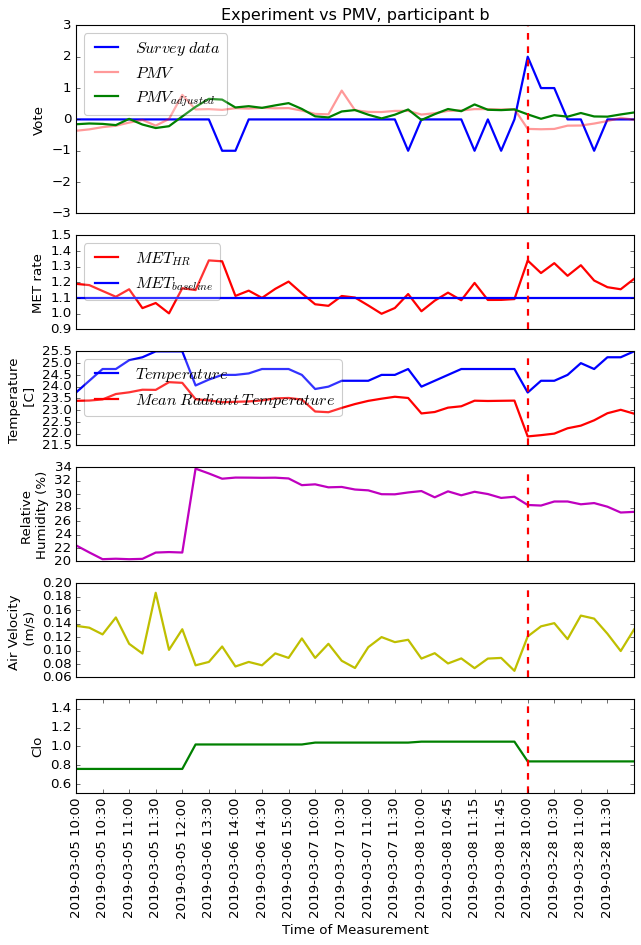

In [0]:
# Participant b


%matplotlib inline
import matplotlib.pyplot as plt
import datetime
plt.style.use('classic')

dataset_unique = dataset[dataset['Subject'] == 'b']

fig, (ax, ax2,ax3,ax4,ax5, ax6) = plt.subplots(6, 1,
                              gridspec_kw={'height_ratios':[2,1,1,1,1, 1]}, 
                              figsize=(9,12))

fig.patch.set_facecolor('white')


dataset_unique['baseline_MET'] = 1.1

ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'General Sensation'], 'b-', label=r'$Survey\;data$', linewidth=2);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'PMV'],  'r-', label= r'$PMV$', linewidth=2, alpha = 0.4);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_PMV'],  'g-', label= r'$PMV_{adjusted}$', linewidth=2);


# # start, end = ax2.get_xlim()
# # xlabels = np.arange(start, end, 10)
# # ax.xaxis.set_ticks(np.arange(start, end, 10))
# # ax.set_xticklabels(xlabels,rotation=90)

# ax.axvspan(dataset['Unnamed: 0'].iloc[0],dataset['Unnamed: 0'].iloc[44], facecolor='m', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[45],dataset['Unnamed: 0'].iloc[87], facecolor='b', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[88],dataset['Unnamed: 0'].iloc[132], facecolor='c', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[133],dataset['Unnamed: 0'].iloc[154], facecolor='g', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[155],dataset['Unnamed: 0'].iloc[187], facecolor='y', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[188],dataset['Unnamed: 0'].iloc[228], facecolor='r', alpha=0.2)

# # ax.plot(dataset['Unnamed: 0'], dataset[ 'NewMET_PMV'],  'm-', label='NewMET_PMV', linewidth=2);
plt.xticks(rotation=90)
ax.legend(fancybox=True, framealpha=0.2, loc = 'upper left');


start, end = ax.get_xlim()
# # ax.xaxis.set_ticks(np.arange(start, end, 10))


ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_MET'],  'r-', label= r'$MET_{HR}$', linewidth=2);
ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'baseline_MET'],  'b-', label= r'$MET_{baseline}$', linewidth=2);

ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Temperature'],  'b-', label= r'$Temperature$', linewidth=2);
ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'MRT'],  'r-', label= r'$Mean\;Radiant\;Temperature$', linewidth=2);


ax4.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'RH'],  'm-', label= r'$Relative\;Humidity$', linewidth=2);

ax5.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'WindSpd'],  'y-', label= r'$Air Velocity$', linewidth=2);

ax6.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Clo'],  'g-', label= r'$Clothing Insulation$', linewidth=2);


# start, end = ax2.get_xlim()
# ax2.xaxis.set_ticks(np.arange(start, end, 10))

ax2.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
ax3.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax4.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax5.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax6.legend(fancybox=True, framealpha=0.2, loc = 'upper left');

ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax.set_xticks([])

# xlabels = np.arange(start, end, 10)
ax6.xaxis.set_ticks(np.arange(start, end, 2))
# ax.set_xticklabels(xlabels,rotation=90)

ax.set_title("Experiment vs PMV, participant b")
plt.xlabel('Time of Measurement')
ax.set_ylabel('Vote');
ax2.set_ylabel('MET rate');
ax3.set_ylabel('Temperature \n [C]');
ax4.set_ylabel('Relative \nHumidity (%)');
ax5.set_ylabel('Air Velocity \n (m/s)');
ax6.set_ylabel('Clo');

# plt.axvline(x= datetime.datetime(2019,3, 28,10,00), color = 'r')

axes = fig.get_axes()

for axis in axes:
  axis.axvline(x= 34, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 34, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 34, color = 'r', linestyle="--",linewidth=2)
# 2019-03-28 10:00

plt.axis('tight');

ax.set_ylim([-3,3]);
ax2.set_ylim([0.9, 1.5]);
ax6.set_ylim([0.5, 1.5]);

filenameExperiment = "ExperimentHR.png"
# pyplot.savefig(filenameExperiment)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


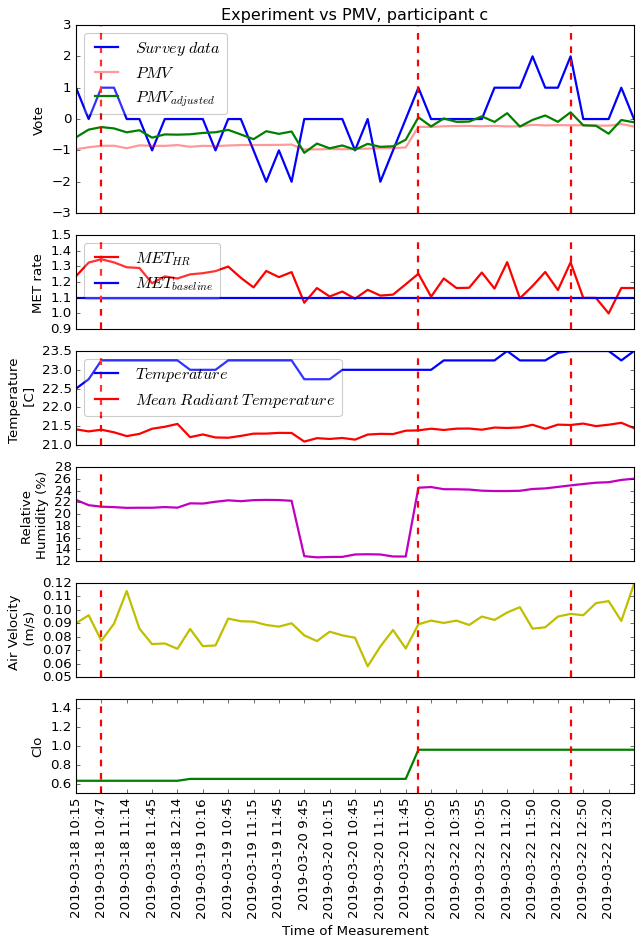

In [0]:
# Participant c


%matplotlib inline
import matplotlib.pyplot as plt
import datetime
plt.style.use('classic')

dataset_unique = dataset[dataset['Subject'] == 'c']

fig, (ax, ax2,ax3,ax4,ax5, ax6) = plt.subplots(6, 1,
                              gridspec_kw={'height_ratios':[2,1,1,1,1, 1]}, 
                              figsize=(9,12))

fig.patch.set_facecolor('white')


dataset_unique['baseline_MET'] = 1.1

ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'General Sensation'], 'b-', label=r'$Survey\;data$', linewidth=2);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'PMV'],  'r-', label= r'$PMV$', linewidth=2, alpha = 0.4);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_PMV'],  'g-', label= r'$PMV_{adjusted}$', linewidth=2);


# # start, end = ax2.get_xlim()
# # xlabels = np.arange(start, end, 10)
# # ax.xaxis.set_ticks(np.arange(start, end, 10))
# # ax.set_xticklabels(xlabels,rotation=90)

# ax.axvspan(dataset['Unnamed: 0'].iloc[0],dataset['Unnamed: 0'].iloc[44], facecolor='m', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[45],dataset['Unnamed: 0'].iloc[87], facecolor='b', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[88],dataset['Unnamed: 0'].iloc[132], facecolor='c', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[133],dataset['Unnamed: 0'].iloc[154], facecolor='g', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[155],dataset['Unnamed: 0'].iloc[187], facecolor='y', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[188],dataset['Unnamed: 0'].iloc[228], facecolor='r', alpha=0.2)

# # ax.plot(dataset['Unnamed: 0'], dataset[ 'NewMET_PMV'],  'm-', label='NewMET_PMV', linewidth=2);
plt.xticks(rotation=90)
ax.legend(fancybox=True, framealpha=0.2, loc = 'upper left');


start, end = ax.get_xlim()
# # ax.xaxis.set_ticks(np.arange(start, end, 10))


ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_MET'],  'r-', label= r'$MET_{HR}$', linewidth=2);
ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'baseline_MET'],  'b-', label= r'$MET_{baseline}$', linewidth=2);

ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Temperature'],  'b-', label= r'$Temperature$', linewidth=2);
ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'MRT'],  'r-', label= r'$Mean\;Radiant\;Temperature$', linewidth=2);


ax4.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'RH'],  'm-', label= r'$Relative\;Humidity$', linewidth=2);

ax5.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'WindSpd'],  'y-', label= r'$Air Velocity$', linewidth=2);

ax6.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Clo'],  'g-', label= r'$Clothing Insulation$', linewidth=2);


# start, end = ax2.get_xlim()
# ax2.xaxis.set_ticks(np.arange(start, end, 10))

ax2.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
ax3.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax4.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax5.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax6.legend(fancybox=True, framealpha=0.2, loc = 'upper left');

ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax.set_xticks([])

# xlabels = np.arange(start, end, 10)
ax6.xaxis.set_ticks(np.arange(start, end, 2))
# ax.set_xticklabels(xlabels,rotation=90)

ax.set_title("Experiment vs PMV, participant c")
plt.xlabel('Time of Measurement')
ax.set_ylabel('Vote');
ax2.set_ylabel('MET rate');
ax3.set_ylabel('Temperature \n [C]');
ax4.set_ylabel('Relative \nHumidity (%)');
ax5.set_ylabel('Air Velocity \n (m/s)');
ax6.set_ylabel('Clo');

# plt.axvline(x= datetime.datetime(2019,3, 28,10,00), color = 'r')

axes = fig.get_axes()
for axis in axes:
  axis.axvline(x= 27, color = 'r', linestyle="--",linewidth=2)
  axis.axvline(x= 2, color = 'r', linestyle="--",linewidth=2)
  axis.axvline(x= 39, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 27, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 27, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 2, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 2, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 39, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 39, color = 'r', linestyle="--",linewidth=2)
# 2019-03-28 10:00

plt.axis('tight');

ax.set_ylim([-3,3]);
ax2.set_ylim([0.9, 1.5]);
ax6.set_ylim([0.5, 1.5]);

filenameExperiment = "ExperimentHR.png"
# pyplot.savefig(filenameExperiment)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


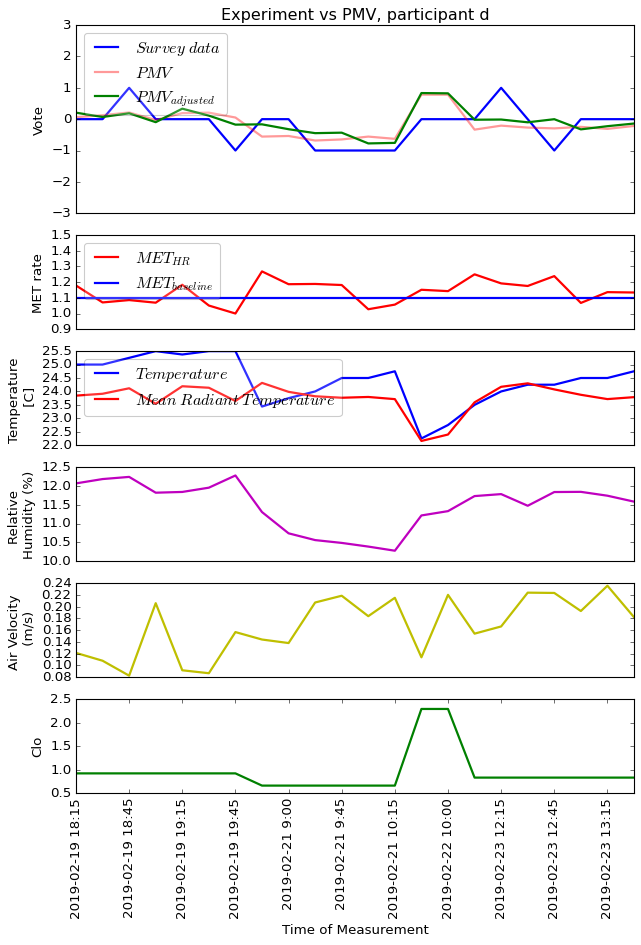

In [0]:
# Participant d


%matplotlib inline
import matplotlib.pyplot as plt
import datetime
plt.style.use('classic')

dataset_unique = dataset[dataset['Subject'] == 'd']

fig, (ax, ax2,ax3,ax4,ax5, ax6) = plt.subplots(6, 1,
                              gridspec_kw={'height_ratios':[2,1,1,1,1, 1]}, 
                              figsize=(9,12))

fig.patch.set_facecolor('white')


dataset_unique['baseline_MET'] = 1.1

ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'General Sensation'], 'b-', label=r'$Survey\;data$', linewidth=2);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'PMV'],  'r-', label= r'$PMV$', linewidth=2, alpha = 0.4);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_PMV'],  'g-', label= r'$PMV_{adjusted}$', linewidth=2);


# # start, end = ax2.get_xlim()
# # xlabels = np.arange(start, end, 10)
# # ax.xaxis.set_ticks(np.arange(start, end, 10))
# # ax.set_xticklabels(xlabels,rotation=90)

# ax.axvspan(dataset['Unnamed: 0'].iloc[0],dataset['Unnamed: 0'].iloc[44], facecolor='m', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[45],dataset['Unnamed: 0'].iloc[87], facecolor='b', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[88],dataset['Unnamed: 0'].iloc[132], facecolor='c', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[133],dataset['Unnamed: 0'].iloc[154], facecolor='g', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[155],dataset['Unnamed: 0'].iloc[187], facecolor='y', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[188],dataset['Unnamed: 0'].iloc[228], facecolor='r', alpha=0.2)

# # ax.plot(dataset['Unnamed: 0'], dataset[ 'NewMET_PMV'],  'm-', label='NewMET_PMV', linewidth=2);
plt.xticks(rotation=90)
ax.legend(fancybox=True, framealpha=0.2, loc = 'upper left');


start, end = ax.get_xlim()
# # ax.xaxis.set_ticks(np.arange(start, end, 10))


ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_MET'],  'r-', label= r'$MET_{HR}$', linewidth=2);
ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'baseline_MET'],  'b-', label= r'$MET_{baseline}$', linewidth=2);

ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Temperature'],  'b-', label= r'$Temperature$', linewidth=2);
ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'MRT'],  'r-', label= r'$Mean\;Radiant\;Temperature$', linewidth=2);


ax4.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'RH'],  'm-', label= r'$Relative\;Humidity$', linewidth=2);

ax5.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'WindSpd'],  'y-', label= r'$Air Velocity$', linewidth=2);

ax6.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Clo'],  'g-', label= r'$Clothing Insulation$', linewidth=2);


# start, end = ax2.get_xlim()
# ax2.xaxis.set_ticks(np.arange(start, end, 10))

ax2.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
ax3.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax4.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax5.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax6.legend(fancybox=True, framealpha=0.2, loc = 'upper left');

ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax.set_xticks([])

# xlabels = np.arange(start, end, 10)
ax6.xaxis.set_ticks(np.arange(start, end, 2))
# ax.set_xticklabels(xlabels,rotation=90)

ax.set_title("Experiment vs PMV, participant d")
plt.xlabel('Time of Measurement')
ax.set_ylabel('Vote');
ax2.set_ylabel('MET rate');
ax3.set_ylabel('Temperature \n [C]');
ax4.set_ylabel('Relative \nHumidity (%)');
ax5.set_ylabel('Air Velocity \n (m/s)');
ax6.set_ylabel('Clo');

# plt.axvline(x= datetime.datetime(2019,3, 28,10,00), color = 'r')

axes = fig.get_axes()

# for axis in axes:
  # axis.axvline(x= 34, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 34, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 34, color = 'r', linestyle="--",linewidth=2)
# 2019-03-28 10:00

plt.axis('tight');

ax.set_ylim([-3,3]);
ax2.set_ylim([0.9, 1.5]);
ax6.set_ylim([0.5, 2.5]);

filenameExperiment = "ExperimentHR.png"
# pyplot.savefig(filenameExperiment)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


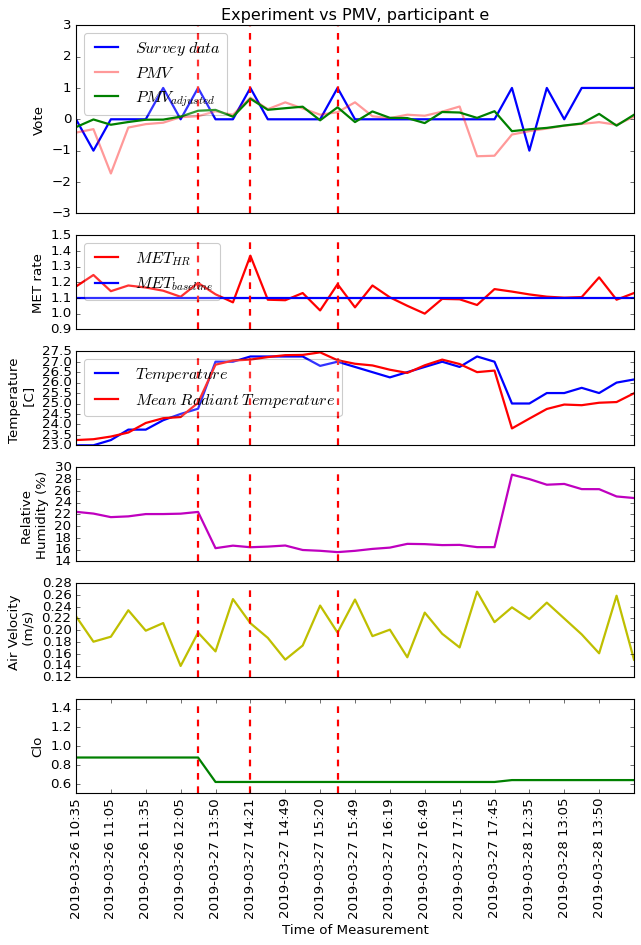

In [0]:
# Participant e


%matplotlib inline
import matplotlib.pyplot as plt
import datetime
plt.style.use('classic')

dataset_unique = dataset[dataset['Subject'] == 'e']

fig, (ax, ax2,ax3,ax4,ax5, ax6) = plt.subplots(6, 1,
                              gridspec_kw={'height_ratios':[2,1,1,1,1, 1]}, 
                              figsize=(9,12))

fig.patch.set_facecolor('white')


dataset_unique['baseline_MET'] = 1.1

ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'General Sensation'], 'b-', label=r'$Survey\;data$', linewidth=2);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'PMV'],  'r-', label= r'$PMV$', linewidth=2, alpha = 0.4);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_PMV'],  'g-', label= r'$PMV_{adjusted}$', linewidth=2);


# # start, end = ax2.get_xlim()
# # xlabels = np.arange(start, end, 10)
# # ax.xaxis.set_ticks(np.arange(start, end, 10))
# # ax.set_xticklabels(xlabels,rotation=90)

# ax.axvspan(dataset['Unnamed: 0'].iloc[0],dataset['Unnamed: 0'].iloc[44], facecolor='m', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[45],dataset['Unnamed: 0'].iloc[87], facecolor='b', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[88],dataset['Unnamed: 0'].iloc[132], facecolor='c', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[133],dataset['Unnamed: 0'].iloc[154], facecolor='g', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[155],dataset['Unnamed: 0'].iloc[187], facecolor='y', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[188],dataset['Unnamed: 0'].iloc[228], facecolor='r', alpha=0.2)

# # ax.plot(dataset['Unnamed: 0'], dataset[ 'NewMET_PMV'],  'm-', label='NewMET_PMV', linewidth=2);
plt.xticks(rotation=90)
ax.legend(fancybox=True, framealpha=0.2, loc = 'upper left');


start, end = ax.get_xlim()
# # ax.xaxis.set_ticks(np.arange(start, end, 10))


ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_MET'],  'r-', label= r'$MET_{HR}$', linewidth=2);
ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'baseline_MET'],  'b-', label= r'$MET_{baseline}$', linewidth=2);

ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Temperature'],  'b-', label= r'$Temperature$', linewidth=2);
ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'MRT'],  'r-', label= r'$Mean\;Radiant\;Temperature$', linewidth=2);


ax4.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'RH'],  'm-', label= r'$Relative\;Humidity$', linewidth=2);

ax5.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'WindSpd'],  'y-', label= r'$Air Velocity$', linewidth=2);

ax6.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Clo'],  'g-', label= r'$Clothing Insulation$', linewidth=2);


# start, end = ax2.get_xlim()
# ax2.xaxis.set_ticks(np.arange(start, end, 10))

ax2.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
ax3.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax4.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax5.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax6.legend(fancybox=True, framealpha=0.2, loc = 'upper left');

ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax.set_xticks([])

# xlabels = np.arange(start, end, 10)
ax6.xaxis.set_ticks(np.arange(start, end, 2))
# ax.set_xticklabels(xlabels,rotation=90)

ax.set_title("Experiment vs PMV, participant e")
plt.xlabel('Time of Measurement')
ax.set_ylabel('Vote');
ax2.set_ylabel('MET rate');
ax3.set_ylabel('Temperature \n [C]');
ax4.set_ylabel('Relative \nHumidity (%)');
ax5.set_ylabel('Air Velocity \n (m/s)');
ax6.set_ylabel('Clo');

# plt.axvline(x= datetime.datetime(2019,3, 28,10,00), color = 'r')

axes = fig.get_axes()
for axis in axes:
  axis.axvline(x= 15, color = 'r', linestyle="--",linewidth=2)
  axis.axvline(x= 10, color = 'r', linestyle="--",linewidth=2)
  axis.axvline(x= 7, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 15, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 15, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 10, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 10, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 7, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 7, color = 'r', linestyle="--",linewidth=2)

# ax2.axvline(x= 30, color = 'r', linestyle="--",linewidth=2)
# ax.axvline(x= 30, color = 'r', linestyle="--",linewidth=2)
# 2019-03-28 10:00

plt.axis('tight');

ax.set_ylim([-3,3]);
ax2.set_ylim([0.9, 1.5]);
ax6.set_ylim([0.5, 1.5]);

filenameExperiment = "ExperimentHR.png"
# pyplot.savefig(filenameExperiment)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


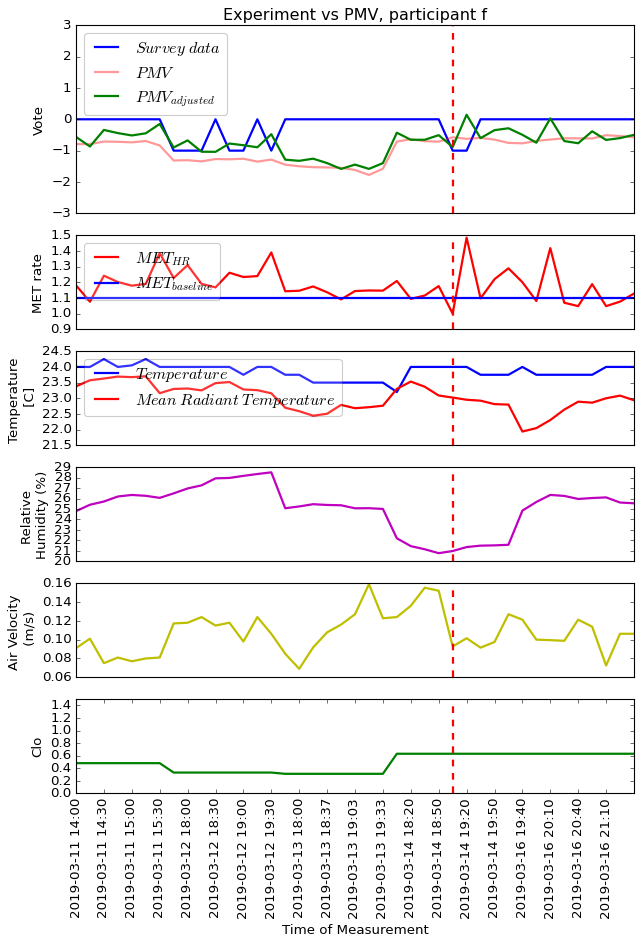

In [0]:
# Participant f


%matplotlib inline
import matplotlib.pyplot as plt
import datetime
plt.style.use('classic')

dataset_unique = dataset[dataset['Subject'] == 'f']

fig, (ax, ax2,ax3,ax4,ax5, ax6) = plt.subplots(6, 1,
                              gridspec_kw={'height_ratios':[2,1,1,1,1, 1]}, 
                              figsize=(9,12))

fig.patch.set_facecolor('white')


dataset_unique['baseline_MET'] = 1.1

ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'General Sensation'], 'b-', label=r'$Survey\;data$', linewidth=2);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'PMV'],  'r-', label= r'$PMV$', linewidth=2, alpha = 0.4);
ax.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_PMV'],  'g-', label= r'$PMV_{adjusted}$', linewidth=2);


# # start, end = ax2.get_xlim()
# # xlabels = np.arange(start, end, 10)
# # ax.xaxis.set_ticks(np.arange(start, end, 10))
# # ax.set_xticklabels(xlabels,rotation=90)

# ax.axvspan(dataset['Unnamed: 0'].iloc[0],dataset['Unnamed: 0'].iloc[44], facecolor='m', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[45],dataset['Unnamed: 0'].iloc[87], facecolor='b', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[88],dataset['Unnamed: 0'].iloc[132], facecolor='c', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[133],dataset['Unnamed: 0'].iloc[154], facecolor='g', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[155],dataset['Unnamed: 0'].iloc[187], facecolor='y', alpha=0.2)
# ax.axvspan(dataset['Unnamed: 0'].iloc[188],dataset['Unnamed: 0'].iloc[228], facecolor='r', alpha=0.2)

# # ax.plot(dataset['Unnamed: 0'], dataset[ 'NewMET_PMV'],  'm-', label='NewMET_PMV', linewidth=2);
plt.xticks(rotation=90)
ax.legend(fancybox=True, framealpha=0.2, loc = 'upper left');


start, end = ax.get_xlim()
# # ax.xaxis.set_ticks(np.arange(start, end, 10))


ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'HR_MET'],  'r-', label= r'$MET_{HR}$', linewidth=2);
ax2.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'baseline_MET'],  'b-', label= r'$MET_{baseline}$', linewidth=2);

ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Temperature'],  'b-', label= r'$Temperature$', linewidth=2);
ax3.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'MRT'],  'r-', label= r'$Mean\;Radiant\;Temperature$', linewidth=2);


ax4.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'RH'],  'm-', label= r'$Relative\;Humidity$', linewidth=2);

ax5.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'WindSpd'],  'y-', label= r'$Air Velocity$', linewidth=2);

ax6.plot(dataset_unique['Unnamed: 0'], dataset_unique[ 'Clo'],  'g-', label= r'$Clothing Insulation$', linewidth=2);


# start, end = ax2.get_xlim()
# ax2.xaxis.set_ticks(np.arange(start, end, 10))

ax2.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
ax3.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax4.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax5.legend(fancybox=True, framealpha=0.2, loc = 'upper left');
# ax6.legend(fancybox=True, framealpha=0.2, loc = 'upper left');

ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax.set_xticks([])

# xlabels = np.arange(start, end, 10)
ax6.xaxis.set_ticks(np.arange(start, end, 2))
# ax.set_xticklabels(xlabels,rotation=90)

ax.set_title("Experiment vs PMV, participant f")
plt.xlabel('Time of Measurement')
ax.set_ylabel('Vote');
ax2.set_ylabel('MET rate');
ax3.set_ylabel('Temperature \n [C]');
ax4.set_ylabel('Relative \nHumidity (%)');
ax5.set_ylabel('Air Velocity \n (m/s)');
ax6.set_ylabel('Clo');

# plt.axvline(x= datetime.datetime(2019,3, 28,10,00), color = 'r')

axes = fig.get_axes()
for axis in axes:
  axis.axvline(x= 27, color = 'r', linestyle="--",linewidth=2)


plt.axis('tight');

ax.set_ylim([-3,3]);
ax2.set_ylim([0.9, 1.5]);
ax6.set_ylim([0, 1.5]);

filenameExperiment = "ExperimentHR.png"
# pyplot.savefig(filenameExperiment)

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("Correlation between actual sensation and PMV",df['General Sensation'].corr(df['PMV']))
print("MSE between actual sensation and PMV",mean_squared_error(df['General Sensation'],df['PMV']))
print("MAE between actual sensation and PMV",mean_absolute_error(df['General Sensation'],df['PMV']))

Correlation between actual sensation and PMV 0.1980041719836451
MSE between actual sensation and PMV 0.6678054464696038
MAE between actual sensation and PMV 0.6472926932974915


In [0]:
print("Correlation between actual sensation and Modified PMV",df['General Sensation'].corr(df['HR_PMV']))
print("MSE between actual sensation and Modified PMV",mean_squared_error(df['General Sensation'],df['HR_PMV']))
print("MAE between actual sensation and Modified PMV",mean_absolute_error(df['General Sensation'],df['HR_PMV']))

Correlation between actual sensation and Modified PMV 0.2058721261003498
MSE between actual sensation and Modified PMV 0.5245721252013009
MAE between actual sensation and Modified PMV 0.5551732318205688


In [0]:
subjects = ['a', 'b', 'c', 'd', 'e', 'f']
rows = ['a', 'b', 'c', 'd', 'e', 'f', 'Total']
cols = ['PMVcorr', 'HRPMVcorr', 'PMVmse', 'HRPMVmse', 'PMVmae', 'HRPMVmae']
correlation = pd.DataFrame(index = rows, columns=cols)
# correlation = correlation.fillna(1)
for person in subjects:
  subset = df.loc[df['Subject'] == person]
  # correlation['corr'] = 0
  correlation['PMVcorr'][person] = subset['General Sensation'].corr(subset['PMV'])
  correlation['PMVmse'][person] = mean_squared_error(subset['General Sensation'],subset['PMV'])
  correlation['PMVmae'][person] = mean_absolute_error(subset['General Sensation'],subset['PMV'])

  # correlation['HRPMVcorr'][person] = subset['General Sensation'].corr(subset['HR_PMV'])
   
  correlation['HRPMVcorr'][person] = subset['General Sensation'].corr(subset['HR_PMV'])
  correlation['HRPMVmse'][person] = mean_squared_error(subset['General Sensation'],subset['HR_PMV'])
  correlation['HRPMVmae'][person] = mean_absolute_error(subset['General Sensation'],subset['HR_PMV'])

#Total

correlation['PMVcorr']['Total'] = df['General Sensation'].corr(df['PMV'])
correlation['PMVmse']['Total'] = mean_squared_error(df['General Sensation'],df['PMV'])
correlation['PMVmae']['Total'] = mean_absolute_error(df['General Sensation'],df['PMV'])

correlation['HRPMVcorr']['Total'] = df['General Sensation'].corr(df['HR_PMV'])
correlation['HRPMVmse']['Total'] = mean_squared_error(df['General Sensation'],df['HR_PMV'])
correlation['HRPMVmae']['Total'] = mean_absolute_error(df['General Sensation'],df['HR_PMV'])

correlation['HRPMVmae']['Total'] = mean_absolute_error(df['General Sensation'],df['HR_PMV'])

correlation['pd_mae'] = (correlation['HRPMVmae']-correlation['PMVmae'])*100/correlation['PMVmae']
correlation['pd_mse'] = (correlation['HRPMVmse']-correlation['PMVmse'])*100/correlation['PMVmse']


In [0]:
# A correlation table. Generated using the code above this. 

correlation = pd.DataFrame(correlation)
correlation = np.round(correlation.astype(float),decimals=2)

correlation.to_csv('CorrError.csv')

correlation

,PMVcorr,HRPMVcorr,PMVmse,HRPMVmse,PMVmae,HRPMVmae,pd_mae,pd_mse
a,0.19,0.02,0.52,0.50,0.57,0.54,-3.72,-3.77
b,-0.37,-0.27,0.50,0.44,0.50,0.46,-8.03,-12.41
c,0.50,0.55,1.05,0.76,0.85,0.71,-16.62,-27.58
d,0.43,0.50,0.30,0.27,0.45,0.41,-8.90,-8.80
e,0.12,0.11,0.59,0.37,0.61,0.44,-27.04,-38.02
f,0.20,-0.07,0.85,0.65,0.81,0.67,-17.38,-23.72
Total,0.20,0.21,0.67,0.52,0.65,0.56,-14.23,-21.45
